<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span><ul class="toc-item"><li><span><a href="#Gimbal-setup" data-toc-modified-id="Gimbal-setup-1.1">Gimbal setup</a></span><ul class="toc-item"><li><span><a href="#Define-params" data-toc-modified-id="Define-params-1.1.1">Define params</a></span></li><li><span><a href="#Traingulation-error-for-each-kp/camera" data-toc-modified-id="Traingulation-error-for-each-kp/camera-1.1.2">Traingulation error for each kp/camera</a></span></li></ul></li></ul></li><li><span><a href="#GIMBAL" data-toc-modified-id="GIMBAL-2">GIMBAL</a></span><ul class="toc-item"><li><span><a href="#Initial-fitting-step-(run-on-all-sessions)" data-toc-modified-id="Initial-fitting-step-(run-on-all-sessions)-2.1">Initial fitting step (run on all sessions)</a></span><ul class="toc-item"><li><span><a href="#Load-poses" data-toc-modified-id="Load-poses-2.1.1">Load poses</a></span></li><li><span><a href="#Fit-GIMBAL-params" data-toc-modified-id="Fit-GIMBAL-params-2.1.2">Fit GIMBAL params</a></span></li><li><span><a href="#Save-GIMBAL-params" data-toc-modified-id="Save-GIMBAL-params-2.1.3">Save GIMBAL params</a></span></li></ul></li><li><span><a href="#Second-fitting-step-(to-each-recording)" data-toc-modified-id="Second-fitting-step-(to-each-recording)-2.2">Second fitting step (to each recording)</a></span><ul class="toc-item"><li><span><a href="#Apply-GIMBAL-to-a-recording" data-toc-modified-id="Apply-GIMBAL-to-a-recording-2.2.1">Apply GIMBAL to a recording</a></span></li></ul></li></ul></li><li><span><a href="#Assess-results" data-toc-modified-id="Assess-results-3">Assess results</a></span></li></ul></div>

In [1]:
import jax
import sys
import glob
import gimbal
import joblib
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import joblib, json, os, h5py
import imageio, cv2
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
import multicam_calibration as mcc
import keypoint_moseq as kpms
from scipy.ndimage import median_filter
jax.config.update("jax_enable_x64", False)



# Setup

In [3]:
# if you see warnings about GPU not found / CPU make sure you:
# 1. are on a GPU node
# 2. module load gcc/9.2.0 and cuda/11.7 or appropriate version
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
import sys
sys.version

'3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) \n[GCC 12.3.0]'

In [5]:
def vector_to_angle(V):
    y,x = V[...,1],V[...,0]+1e-10
    angles = (np.arctan(y/x)+(x>0)*np.pi)%(2*np.pi)-np.pi
    return angles

def angle_to_rotation_matrix(h, keypoint_dim=3):
    m = np.tile(np.eye(keypoint_dim), (*h.shape,1,1))
    m[...,0,0] = np.cos(h)
    m[...,1,1] = np.cos(h)
    m[...,0,1] = -np.sin(h)
    m[...,1,0] = np.sin(h)
    return m

def standardize_poses(poses, indices_egocentric):
    poses = poses - poses.mean(1, keepdims=True)
    front = poses[:,indices_egocentric[1],:2]
    back = poses[:,indices_egocentric[0],:2]
    angle = vector_to_angle(front-back)
    rot = angle_to_rotation_matrix(angle, keypoint_dim=poses.shape[-1])
    return poses @ rot

def compute_directions(poses, parents):
    dirs = poses - poses[:, parents]
    dirs /= (np.linalg.norm(dirs, axis=-1, keepdims=True)+1e-16)
    return dirs[~np.isnan(dirs).any((1,2))]


def fit_gimbal_model(dirs, num_states, num_iters):
    
    key = jr.PRNGKey(1)
    dirs = jnp.array(dirs)
    
    em_output = gimbal.fit.em_movMF(key, dirs[:,1:], num_states, num_iters)
    lls, E_zs, pis_em, mus_em, kappas_em = map(np.array, em_output)
    
    kappas_root = np.zeros((num_states,1))
    mu_root = (np.arange(dirs.shape[-1])==0).astype(float)
    mus_root = np.tile(mu_root, (num_states,1,1))
    
    kappas_em = np.concatenate([kappas_root, kappas_em], axis=1)
    mus_em = np.concatenate([mus_root, mus_em], axis=1)

    return lls, pis_em, mus_em, kappas_em


def generate_gimbal_params(
    camera_matrices, 
    fitted_params,
    obs_outlier_variance,
    pos_dt_variance,
    num_leapfrog_steps=5,
    step_size = 1e-1,
    dtype='float32'):
    
    num_cameras, num_joints = fitted_params['obs_inlier_variance'].shape

    params = {
        'obs_outlier_probability' : jnp.zeros((num_cameras, num_joints), dtype),
        'obs_outlier_location': jnp.zeros((num_cameras, num_joints,2), dtype),
        'obs_outlier_variance': jnp.ones((num_cameras, num_joints), dtype)*obs_outlier_variance,
        'obs_inlier_location': jnp.zeros((num_cameras, num_joints,2), dtype),
        'obs_inlier_variance': jnp.array(fitted_params['obs_inlier_variance'], dtype),
        'camera_matrices': jnp.array(camera_matrices, dtype),
        'pos_radius': jnp.array(fitted_params['radii'], dtype),
        'pos_radial_variance': jnp.array([1e8,*fitted_params['radii_std'][1:]**2], dtype),
        'parents': jnp.array(fitted_params['parents']),
        'pos_dt_variance': jnp.ones(num_joints, dtype)*pos_dt_variance,
        'state_probability': jnp.array(fitted_params['pis'], dtype),
        'state_directions': jnp.array(fitted_params['mus'], dtype),
        'state_concentrations': jnp.array(fitted_params['kappas'], dtype),
        'crf_keypoints': fitted_params['indices_egocentric'][::-1],
        'crf_abscissa': jnp.zeros(3, dtype).at[0].set(1),
        'crf_normal': jnp.zeros(3, dtype).at[2].set(1),
        'crf_axes': jnp.eye(3).astype(dtype),
        'state_transition_count': jnp.ones(len(fitted_params['pis']), dtype),
        'step_size': step_size, 'num_leapfrog_steps':num_leapfrog_steps,
    }
    return gimbal.mcmc3d_full.initialize_parameters(params)


def generate_initial_positions(positions):
    init_positions = np.zeros_like(positions)
    for k in range(positions.shape[1]):
        ix = np.nonzero(~np.isnan(positions[:,k,0]))[0]
        for i in range(positions.shape[2]):
            init_positions[:,k,i] = np.interp(
                np.arange(positions.shape[0]),
                ix, positions[:,k,i][ix])
    return init_positions
        
    
def generate_outlier_probs(confidence,     
    outlier_prob_bounds=[1e-3,1-1e-6],
    conf_sigmoid_center=0.3,
    conf_sigmoid_gain=20):
    
    outlier_p = jax.nn.sigmoid((conf_sigmoid_center-confidence)*conf_sigmoid_gain)
    return jnp.clip(outlier_p, *outlier_prob_bounds)



## Gimbal setup

### Define params

In [ ]:
import yaml
from keypoint_sort.util import build_node_hierarchy
from keypoint_moseq.util import get_edges

bodyparts = ['tail_tip',
             'tail_base',
             'spine_low',
             'spine_mid',
             'spine_high',
             'left_ear',
             'right_ear',
             'forehead',
             'nose_tip',
             'left_hind_paw_front',
             'left_hind_paw_back',
             'right_hind_paw_front',
             'right_hind_paw_back',
             'left_fore_paw',
             'right_fore_paw']

skeleton = [
    ['tail_base', 'spine_low'],
    ['spine_low', 'spine_mid'],
    ['spine_mid', 'spine_high'],
    ['spine_high', 'left_ear'],
    ['spine_high', 'right_ear'],
    ['spine_high', 'forehead'],
    ['forehead', 'nose_tip'],
    ['left_hind_paw_back', 'left_hind_paw_front'],
    ['spine_low', 'left_hind_paw_back'],
    ['right_hind_paw_back', 'right_hind_paw_front'],
    ['spine_low', 'right_hind_paw_back'],
    ['spine_high', 'left_fore_paw'],
    ['spine_high', 'right_fore_paw']
]


use_bodyparts = bodyparts[1:]
use_bodyparts_idx = np.array([bodyparts.index(bp) for bp in use_bodyparts])
edges = np.array(get_edges(use_bodyparts, skeleton))
node_order, parents = build_node_hierarchy(use_bodyparts, skeleton, 'spine_low')
edges = np.argsort(node_order)[edges]
indices_egocentric = [0,2]
num_iters = 1000
num_states = 50

2023-11-28 10:07:35.063956: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-11-28 10:07:35.288202: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-11-28 10:07:35.301723: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-11-28 10

### Traingulation error for each kp/camera

In [ ]:
calib_mapping = {
    '20230904_J01601':'20230904_calibration',
    '20230905_J01601':'20230905_calibration',
    
    '20230904_J01602':'20230904_calibration',
    '20230905_J01602':'20230905_calibration',
    
    '20230904_J01701':'20230904_calibration',
    '20230905_J01701':'20230905_calibration',
    '20230911_J01701':'20230911_calibration',
    '20230912_J01701':'20230912_calibration',
    
    '20230905_J01702':'20230905_calibration',
    '20230911_J01702':'20230911_calibration',
    '20230912_J01702':'20230912_calibration',
    
    '20230904_J01703':'20230904_calibration',
    '20230908_J01703':'20230908_calibration',
    '20230911_J01703':'20230911_calibration',
    '20230912_J01703':'20230912_calibration',
    
}

In [14]:
all_errors = []
for vid,calib in tqdm.tqdm(calib_mapping.items()):
    calib_path = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/'+calib+'/camera_params.h5'
    all_extrinsics, all_intrinsics, camera_names = mcc.load_calibration(calib_path, 'gimbal')
    
    mouse = vid.split('_')[-1]
    vid_dir = f'/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/{mouse}/{vid}'
    pose = np.load(f'{vid_dir}/robust_triangulation.npy')[::10]
    
    errors = []
    for i,c in enumerate(camera_names):
        with h5py.File(f'{vid_dir}/{c}.keypoints.h5','r') as h5:
            uvs = h5['uv'][()][::10]
            uvs[h5['conf'][()][::10] < 0.25] = np.nan
            uvs_pred = mcc.project_points(pose, all_extrinsics[i], *all_intrinsics[i])
            errors.append(np.sqrt(((uvs-uvs_pred)**2).sum(-1)))
    all_errors.append(np.stack(errors))
all_errors = np.concatenate(all_errors,axis=1)[:,:,use_bodyparts_idx][:,:,node_order]

  0%|          | 0/15 [00:00<?, ?it/s]

All-NaN slice encountered

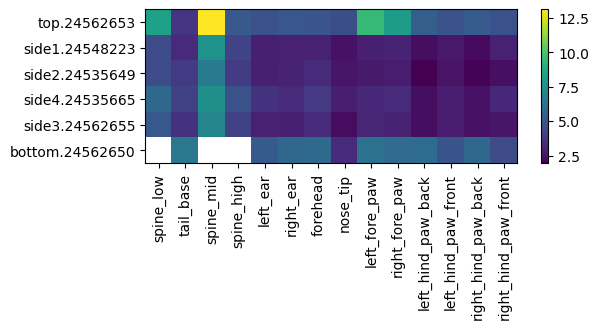

In [15]:
median_error = np.nanmedian(all_errors, axis=1)
plt.imshow(median_error, aspect='auto')
plt.colorbar()
plt.xticks(range(len(use_bodyparts)), [use_bodyparts[i] for i in node_order], rotation=90)
plt.yticks(range(len(camera_names)),camera_names);
plt.gcf().set_size_inches((6,2))

In [16]:
max_inlier_var = 100
obs_inlier_variance = np.minimum(median_error**2, max_inlier_var)
obs_inlier_variance[np.isnan(obs_inlier_variance )] = max_inlier_var

# GIMBAL

## Initial fitting step (run on all sessions)

### Load poses

In [ ]:
good_sessions = [
    
    # J016 are older, may want to exclude from ultimate model
    '20230904_J01601',
    '20230905_J01601',
    
    '20230904_J01602',
    '20230905_J01602',
    
    '20230904_J01701',
    '20230905_J01701',
    '20230911_J01701',
    '20230912_J01701',
    
    '20230905_J01702',
    '20230911_J01702',
    '20230912_J01702',
    
    '20230904_J01703',
    '20230908_J01703',
    '20230911_J01703',
    '20230912_J01703',
]

poses = []
for k in good_sessions:
    mouse = k.split('_')[-1]
    poses.append(np.load(f'/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/{mouse}/{k}/robust_triangulation.npy'))
poses = np.concatenate(poses)[:,use_bodyparts_idx]
poses = poses[(~np.isnan(poses)).all((1,2))]
poses_standard = standardize_poses(poses[:,node_order], indices_egocentric)

In [18]:
from keypoint_moseq.viz import plot_poses_3D
X = poses_standard[np.random.choice(len(poses), 20, replace=False)]
X = X * np.array([1,1,-1])[None,None,:]
from keypoint_moseq.viz import plot_poses_3D
plot_poses_3D(X, edges)

### Fit GIMBAL params

In [19]:
radii = np.sqrt(((poses - poses[:,parents])**2).sum(-1))
directions = compute_directions(poses_standard, parents)
lls, pis_em, mus_em, kappas_em = fit_gimbal_model(directions, num_states, num_iters)

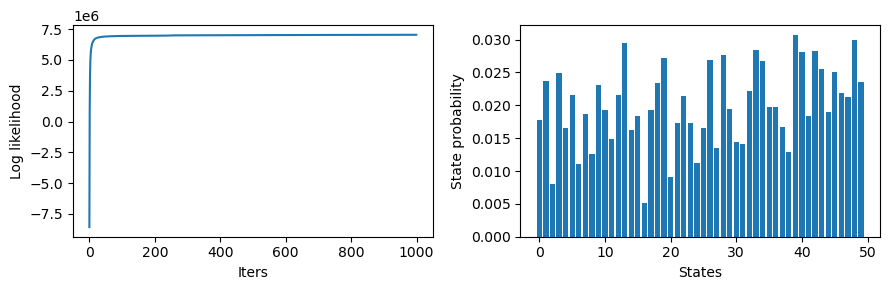

In [20]:
fig,axs = plt.subplots(1,2)
axs[0].plot(lls)
axs[0].set_xlabel('Iters')
axs[0].set_ylabel('Log likelihood')
axs[1].bar(range(num_states), pis_em)
axs[1].set_xlabel('States')
axs[1].set_ylabel('State probability')
fig.set_size_inches((9,3))
plt.tight_layout()

### Save GIMBAL params

In [21]:
params = {
    'obs_inlier_variance': obs_inlier_variance,
    'indices_egocentric': indices_egocentric,
    'parents': parents,
    'radii' : np.mean(radii,axis=0),
    'radii_std' : np.std(radii,axis=0),
    'kappas' : kappas_em,
    'mus' : mus_em,
    'pis' : pis_em}

joblib.dump(params, 'gimbal_params.p')

['gimbal_params.p']

## Second fitting step (to each recording)

### Apply GIMBAL to a recording

In [99]:

import yaml
from keypoint_sort.util import build_node_hierarchy
from keypoint_moseq.util import get_edges

bodyparts = ['tail_tip',
             'tail_base',
             'spine_low',
             'spine_mid',
             'spine_high',
             'left_ear',
             'right_ear',
             'forehead',
             'nose_tip',
             'left_hind_paw_front',
             'left_hind_paw_back',
             'right_hind_paw_front',
             'right_hind_paw_back',
             'left_fore_paw',
             'right_fore_paw']

skeleton = [
    ['tail_base', 'spine_low'],
    ['spine_low', 'spine_mid'],
    ['spine_mid', 'spine_high'],
    ['spine_high', 'left_ear'],
    ['spine_high', 'right_ear'],
    ['spine_high', 'forehead'],
    ['forehead', 'nose_tip'],
    ['left_hind_paw_back', 'left_hind_paw_front'],
    ['spine_low', 'left_hind_paw_back'],
    ['right_hind_paw_back', 'right_hind_paw_front'],
    ['spine_low', 'right_hind_paw_back'],
    ['spine_high', 'left_fore_paw'],
    ['spine_high', 'right_fore_paw']
]


use_bodyparts = bodyparts[1:]
use_bodyparts_ix = np.array([bodyparts.index(bp) for bp in use_bodyparts])
edges = np.array(get_edges(use_bodyparts, skeleton))
node_order, parents = build_node_hierarchy(use_bodyparts, skeleton, 'spine_low')
edges = np.argsort(node_order)[edges]
fitted_params = joblib.load('gimbal_params.p')
fitted_params['obs_inlier_variance'] = np.ones_like(fitted_params['obs_inlier_variance'])*25



In [101]:
calib_path = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/20230904_calibration/camera_params.h5'
vid_dir = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230904_J01601'

all_extrinsics, all_intrinsics, camera_names = mcc.load_calibration(calib_path, 'gimbal')


observations = []
confidence = []
for i,c in tqdm.tqdm(enumerate(camera_names)):
    with h5py.File(f'{vid_dir}/{c}.keypoints.h5','r') as h5:
        uvs = h5['uv'][()][:,use_bodyparts_ix][:,node_order]
        uvs = mcc.undistort_points(uvs, *all_intrinsics[i])
        observations.append(uvs)
        confidence.append(h5['conf'][()][:,use_bodyparts_ix][:,node_order])
        
observations = np.stack(observations,axis=1)
confidence = np.stack(confidence,axis=1)
triangulation_positions = np.load(f'{vid_dir}/robust_triangulation.npy')[:,use_bodyparts_ix][:,node_order]

0it [00:00, ?it/s]

In [102]:

camera_matrices = np.array([
    mcc.get_projection_matrix(extrinsics, intrinsics)
    for extrinsics, intrinsics in zip(all_extrinsics, all_intrinsics)])

params = generate_gimbal_params(camera_matrices, fitted_params, 1e6, 1, step_size=.4)

# initialize positions
init_positions = generate_initial_positions(triangulation_positions)

# calculate probabilies
outlier_prob = generate_outlier_probs(
    confidence, outlier_prob_bounds=[1e-6, 1-1e-6], 
    conf_sigmoid_center=0.5,
    conf_sigmoid_gain=20)


# initialize gimbal state
init_positions = jnp.array(init_positions, 'float32')[:2000]
observations = jnp.array(observations, 'float32')[:2000]
outlier_prob = jnp.array(outlier_prob, 'float32')[:2000]
samples = gimbal.mcmc3d_full.initialize(
    jr.PRNGKey(0), params, observations, outlier_prob, init_positions)

In [103]:

num_iterations = 1000
positions_hist = []
sanples_hist = []
log_likelihood = []

pbar = tqdm.trange(num_iterations)
for itr in pbar:

    samples = gimbal.mcmc3d_full.step(jr.PRNGKey(itr), params, observations, outlier_prob, samples)
    log_likelihood.append(samples['log_probability'].item())

    if itr % 5 == 0:
        sanples_hist.append(jax.device_get(samples))
    
    pbar.set_description(
        "ll={:.2f}".format(log_likelihood[-1])
    )
        

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
[use_bodyparts[i] for i in node_order]

['spine_low',
 'tail_base',
 'spine_mid',
 'spine_high',
 'left_ear',
 'right_ear',
 'forehead',
 'nose_tip',
 'left_fore_paw',
 'right_fore_paw',
 'left_hind_paw_back',
 'left_hind_paw_front',
 'right_hind_paw_back',
 'right_hind_paw_front']

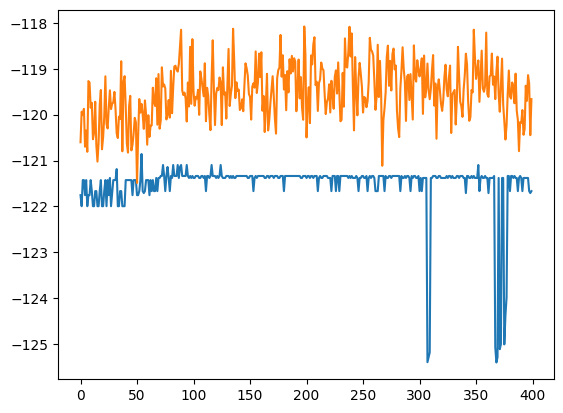

In [92]:
plt.plot(triangulation_positions[:400,11,0])
plt.plot(sanples_hist[-1]['positions'][:400,11,0])

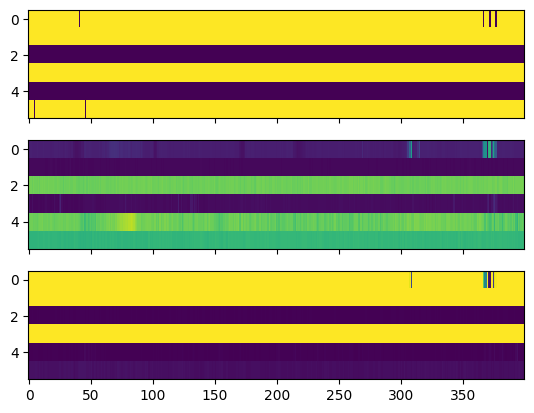

In [94]:
fig,axs = plt.subplots(3,1,sharex=True)
axs[0].imshow(sanples_hist[-1]['outliers'][:400,:,11].T, aspect='auto', interpolation='nearest')
axs[1].imshow(confidence[:400,:,11].T, vmin=0, vmax=1, aspect='auto', interpolation='nearest')
axs[2].imshow(outlier_prob[:400,:,11].T, vmin=0, vmax=1, aspect='auto', interpolation='nearest')

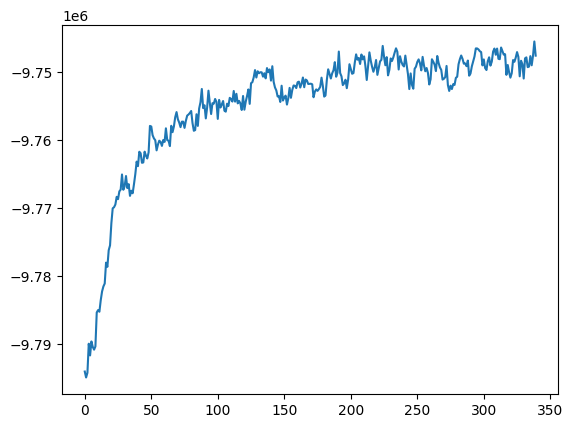

In [95]:
plt.plot(log_likelihood[20:])

In [ ]:
'''
num_iterations = 5000
positions_sum = np.zeros_like(init_positions)
tot = 0

log_likelihood = []
prop_outliers = []

pbar = tqdm.trange(num_iterations)
for itr in pbar:

    samples = gimbal.mcmc3d_full.step(jr.PRNGKey(itr), params, observations, outlier_prob, samples)
    log_likelihood.append(samples['log_probability'].item())
    prop_outliers.append(samples['outliers'].mean().item())

    if itr % 5 == 0 and itr > 8000:
        positions_sum += np.array(samples['positions'])
        tot += 1
    
    pbar.set_description(
        "ll={:.2f} outliers={:.5f}".format(log_likelihood[-1], prop_outliers[-1])
    )
        
    
positions_mean = positions_sum / tot
np.save(f'{vid_dir}/gimbal.npy', positions_mean)
'''

In [96]:
len(sanples_hist)

72

In [97]:
positions_mean = np.mean([s['positions'] for s in sanples_hist[:-20]],axis=0)
np.save(f'{vid_dir}/gimbal.npy', positions_mean)

# Assess results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
good_sessions = [
    
    # J016 are older, may want to exclude from ultimate model
    '20230904_J01601',
    '20230905_J01601',
    
    '20230904_J01602',
    '20230905_J01602',
    
    '20230904_J01701',
    '20230905_J01701',
    '20230911_J01701',
    '20230912_J01701',
    
    '20230905_J01702',
    '20230911_J01702',
    '20230912_J01702',
    
    '20230904_J01703',
    '20230908_J01703',
    '20230911_J01703',
    '20230912_J01703',
]

In [4]:
good_sessions = ['20230911_J01701']
for k in good_sessions:
    mouse = k.split('_')[-1]
    ll = np.load(f'/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/{mouse}/{k}/ll.npy')
    break

FileNotFoundError: [Errno 2] No such file or directory: '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01701/20230911_J01701/ll.npy'